# Preprocess

In [1]:
#coding:utf-8
#the merge part is forked from mapodoufu
import time
import pandas as pd
import numpy as np

# 读取数据
part_1 = pd.read_csv('../data/meinian_round1_data_part1_20180408.txt',sep='$')
part_2 = pd.read_csv('../data/meinian_round1_data_part2_20180408.txt',sep='$')
part_1_2 = pd.concat([part_1,part_2],axis = 0)
part_1_2 = pd.DataFrame(part_1_2).sort_values('vid').reset_index(drop=True)
begin_time = time.time()
print('begin')
# 重复数据的拼接操作
def merge_table(df):
    df['field_results'] = df['field_results'].astype(str)
    if df.shape[0] > 1:
        merge_df = " ".join(list(df['field_results']))
    else:
        merge_df = df['field_results'].values[0]
    return merge_df
# 数据简单处理
print('find_is_copy')
print(part_1_2.shape)
is_happen = part_1_2.groupby(['vid','table_id']).size().reset_index()
# 重塑index用来去重
is_happen['new_index'] = is_happen['vid'] + '_' + is_happen['table_id']
is_happen_new = is_happen[is_happen[0]>1]['new_index']

part_1_2['new_index'] = part_1_2['vid'] + '_' + part_1_2['table_id']

unique_part = part_1_2[part_1_2['new_index'].isin(list(is_happen_new))]
unique_part = unique_part.sort_values(['vid','table_id'])
no_unique_part = part_1_2[~part_1_2['new_index'].isin(list(is_happen_new))]
print('begin')
part_1_2_not_unique = unique_part.groupby(['vid','table_id']).apply(merge_table).reset_index()
part_1_2_not_unique.rename(columns={0:'field_results'},inplace=True)
print('xxx')
tmp = pd.concat([part_1_2_not_unique,no_unique_part[['vid','table_id','field_results']]])
# 行列转换
print('finish')
tmp = tmp.pivot(index='vid',values='field_results',columns='table_id')
#tmp.to_csv('./input/tmp.csv')
print(tmp.shape)
print('totle time',time.time() - begin_time)
tmp.replace('未查',np.nan,inplace=True)
tmp.replace('弃查',np.nan,inplace=True)
import gc
del part_1,part_2,part_1_2,is_happen,is_happen_new,unique_part,no_unique_part,part_1_2_not_unique
gc.collect()
#import pickle
#with open('.\\input\\tmp.pk', 'wb') as f:
#     pickle.dump(tmp, f)

begin
find_is_copy
(8104368, 3)
begin
xxx
finish
(57298, 2795)
totle time 101.05088806152344


48

In [2]:
data_feat = dict()

data_feat['all_feat'] = set(tmp.columns)

In [3]:
feat_tmp_ditch = []
for s in data_feat['all_feat']:
    if tmp[s].isnull().mean() > 0.95:
        feat_tmp_ditch.append(s)

data_feat['ditch'] = set(feat_tmp_ditch)

In [4]:
feat_tmp_words = []
for s in data_feat['all_feat'] - data_feat['ditch']:
    if tmp[s].dropna().str.len().mean() > 5:
        feat_tmp_words.append(s)

feat_tmp_words = set(feat_tmp_words) - set(['3301', '100014', '1474', '269011', '191', '1104', '669009', '809045', '669007', '1345'])

data_feat['words'] = feat_tmp_words

In [5]:
feat_tmp_num_1 = []
for s in data_feat['all_feat'] - data_feat['ditch'] - data_feat['words']:
    try:
        tmp[s].astype(float)
    except:pass
    else:
        feat_tmp_num_1.append(s)

data_feat['num'] = set(feat_tmp_num_1)

feat_tmp_num_2 = [] # suspicious numerical features
for s in data_feat['all_feat'] - data_feat['ditch'] - data_feat['words'] - data_feat['num']:
    if tmp[s].dropna().str.contains('\d').mean() > 0.8:
        feat_tmp_num_2.append(s)

data_feat['num_ish'] = set(feat_tmp_num_2)

In [6]:
data_feat['cat'] = data_feat['all_feat'] - data_feat['ditch'] - data_feat['words'] - data_feat['num'] - data_feat['num_ish']

In [7]:
out = tmp[list(data_feat['num_ish'])]
out.replace(r'．', '.', regex = True, inplace = True)
out.replace(r'０', '0', regex = True, inplace = True)
out.replace(r'１', '1', regex = True, inplace = True)
out.replace(r'２', '2', regex = True, inplace = True)
out.replace(r'３', '3', regex = True, inplace = True)
out.replace(r'４', '4', regex = True, inplace = True)
out.replace(r'５', '5', regex = True, inplace = True)
out.replace(r'６', '6', regex = True, inplace = True)
out.replace(r'７', '7', regex = True, inplace = True)
out.replace(r'８', '8', regex = True, inplace = True)
out.replace(r'９', '9', regex = True, inplace = True)
out = out.replace(['/', r'^详见', r'^未做', r'^未查', r'^-+$', r'退检$'], np.nan, regex=True)
out.replace(r'^<(.)*$', r'\1', regex = True, inplace = True)
out.replace(r'^>(.)*$', r'\1', regex = True, inplace = True)
out.replace(r'^阴性$', 0, regex = True, inplace = True)
out.replace(r'^未见$', 0, regex = True, inplace = True)
rep_fun = lambda x: str(np.nanmean([float(i) for i in x.group(0).split()]))

for s in out.columns:
    out.loc[:, s] = out.loc[:, s].str.replace(r'^(([+-]?[0-9]*[.]?[0-9]+)|nan) (([+-]?[0-9]*[.]?[0-9]+)|nan)$', rep_fun)
    out.loc[:, s] = out.loc[:, s].str.replace(r'^(([+-]?[0-9]*[.]?[0-9]+)|nan) (([+-]?[0-9]*[.]?[0-9]+)|nan) (([+-]?[0-9]*[.]?[0-9]+)|nan)$', rep_fun)
    out.loc[:, s] = out.loc[:, s].str.replace(r'^(([+-]?[0-9]*[.]?[0-9]+)|nan) (([+-]?[0-9]*[.]?[0-9]+)|nan) (([+-]?[0-9]*[.]?[0-9]+)|nan) (([+-]?[0-9]*[.]?[0-9]+)|nan)$', rep_fun)

out.replace([r'^<=([+-]?[0-9]*[.]?[0-9]+)$', r'^>=([+-]?[0-9]*[.]?[0-9]+)$',\
            r'^＜([+-]?[0-9]*[.]?[0-9]+)$', r'^＞([+-]?[0-9]*[.]?[0-9]+)$', \
            r'^＜＝([+-]?[0-9]*[.]?[0-9]+)$', r'^＞＝([+-]?[0-9]*[.]?[0-9]+)$'], r'\1', regex = True, inplace=True)

out.replace(r'。', '.', regex = True, inplace = True)

out.replace(r'^\s*(\S*)\s*$', r'\1', regex = True, inplace = True)

out.replace([r'^(.+)S$', r'^(.+)\.$'], r'\1', regex = True, inplace = True)

out.replace(r'^(\d+)\.\.(\d+)$', r'\1.\2', regex = True, inplace = True)

out.replace(['+', '.'], np.nan, regex=False, inplace = True)

out.replace(r'^([+-]?[0-9]*[.]?[0-9]+)-$', r'\1', regex=True, inplace = True)

out.replace(r'^([+-]?[0-9]*[.]?[0-9]+)kpa$', r'\1', regex=True, inplace = True)

# 2404
out['2404'] = out['2404'].str.replace(r'^(\d+) (\S+)$', r'\1')

# 1325
out['1325'][out['1325'].dropna()[out['1325'].dropna().str.match(r'义眼|光感|失明|弃查|指数|正常')].index] = np.nan

out['1325']['0a67044b74d49b6d9e1a9a7c06a0731e'] = 0.8
out['1325']['115e39811df6cdc8c70bd0d58f555558'] = 1.0
out['1325']['1170d101f8f0dd7ab8c005b9fe0bdb68'] = 1.2
out['1325']['76f813be607bf630e29045b07c6e1e1a'] = 1.5
out['1325']['8096e0132a874a4181a7643fd5e3493a'] = np.nan
out['1325']['a8b397c1c014e2db76ec8f360d680283'] = np.nan
out['1325']['af5109d1a04fcdd4ff06bd42745bdfcc'] = np.nan
out['1325']['cca0f6c8bfbd8d0ddf167083a3a29ecd'] = 1.2

# 1815

out['1815']['62bdd9d1540d90a89281ca820f4d69bb'] = np.nan

# 2409

out['2409'] = out['2409'].str.replace(r'^(.+)\(.+\)$', r'\1')

out['2409'] = out['2409'].str.replace(r'^(.+)%$', r'\1')

out['2409'] = out['2409'].str.replace(r'^(.+)% $', r'\1')

# 300009


out['300009']['8a5390a401a3f13d03480f8340140148'] = 45.21

# 1112


out['1112'] = out['1112'].str.replace(r'^(.+) %$', r'\1')

# 269013


rep_fun_2 = lambda x: str(np.nanmean([float(i) for i in x.group(0).split('-')]))
out['269013'] = out['269013'].str.replace(r'^(\d)-(\d)$', rep_fun_2)

# 300078

out['300078']['662d00fbf6636f3b3c311189e99aac30'] = np.nan

# 10004


out['10004']['561416800096bedd9cf6fbad7cef0ef7'] = 3.7

# A701
out['A701']['d0b81951043aa245b46e3f110af60a7f'] = 6.3

# 0424

out['0424'] = out['0424'].str.replace(r'^\D+(\d+)$', r'\1')
out['0424'] = out['0424'].str.replace(r'^(\d+)\D+$', r'\1')

out['0424'] = out['0424'].str.replace('心动过缓', '60')
out['0424'] = out['0424'].str.replace('心率正常', '80')
out['0424'] = out['0424'].str.replace('未见异常', '80')
out['0424'] = out['0424'].str.replace('正常', '80')
out['0424'] = out['0424'].str.replace('窦性心动过缓', '60')
out['0424'] = out['0424'].str.replace('窦性心动过速', '100')

out['0424'] = out['0424'].str.replace('窦性60', '60') # 竟然不是整句匹配

out['0424']['8c6551f10e8610fcadd93970fd9ff482'] = 75

# 312

out['312'] = out['312'].str.replace(r'(?:\s|^)(\d+)-(\d+)(?:\s|$)', lambda x: ' '+rep_fun_2(x)+' ')

out['312'] = out['312'].str.replace(r'^(.+) $', r'\1')
out['312'] = out['312'].str.replace(r'^ (.+)$', r'\1')

out['312'] = out['312'].str.replace('未见', 'nan')

out['312'] = out['312'].str.replace('+', '')
out['312'] = out['312'].str.replace(r'^(.+) $', r'\1')
out['312'] = out['312'].str.replace(r'^ (.+)$', r'\1')

out['312'] = out['312'].str.replace(r'^(([+-]?[0-9]*[.]?[0-9]+)|nan) (([+-]?[0-9]*[.]?[0-9]+)|nan)$', rep_fun)

# 191

out['191'] = out['191'].str.replace('降脂后复查', 'nan')

not_num = lambda this_feat:out[this_feat].dropna()[~out[this_feat].dropna().str.match('^(?:[+-]?([0-9]*[.])?[0-9]+|nan)$')]

# 1320

out['1320'] = out['1320'].str.replace(r' 正常.*$', '')

out['1320'] = out['1320'].str.replace(r'mmHg$', '')

out['1320'] = out['1320'].str.replace(r'^(\d+)\D+$', r'\1')

out['1320'] = out['1320'].str.replace(r'^.*正常.*$', '15')

out['1320'] = out['1320'].str.replace(r'^.*高.*$', '20')

out['1320'][not_num('1320').index] = 'nan'

# 313

out['313']['efc9d79c3cfca3c5eaef9ebce428bac2'] = 189

# 300017
out['300017']['f32fc7e0d65c3f0ef11dba36284b99f4'] = 1.496

# 2403

out['2403'] = out['2403'].str.replace(r'^(\d+)\s\S+$', r'\1')

# 2372

out['2372']['e50b5c308f0cb33351479f92667f933b'] = (2.79 + 2.20)/2

# 300013

out['300013']['53027913d6c15b82098658f3b358ffad'] = (6.31 + 0.45) / 2

# 300076
out['300076']['662d00fbf6636f3b3c311189e99aac30'] = np.nan

# 192

out['192']['f9d1b02f5579d4e73ac833775724fbc2'] = np.nan

# 1319

out['1319'] = out['1319'].str.replace(r' 正常范围.*$', '')

out['1319'] = out['1319'].str.replace(r'mmHg$', '')

out['1319'] = out['1319'].str.replace(r'^(\d+)\D+$', r'\1')

out['1319'] = out['1319'].str.replace(r'^.*正常.*$', '15')

out['1319'] = out['1319'].str.replace(r'^.*高.*$', '20')

out['1319'][not_num('1319').index] = 'nan'

## 1322
out['1322'][out['1322'].dropna()[out['1322'].dropna().str.match(r'义眼|光感|失明|弃查|指数|正常|无光感|手动|因无法配合不能检测|未要求检查')].index] = np.nan

out['1322'][not_num('1322').index] = ['0.9', 'nan', '0.8', 'nan', '1.2', '1.2', 'nan', '0.8', '1.0', 'nan', '0.9',\
                                     'nan', 'nan']

## 1326

out['1326'][out['1326'].dropna()[out['1326'].dropna().str.match(r'义眼|光感|失明|弃查|指数|正常|无光感|手动|因无法配合不能检测|未要求检查')].index] = np.nan

out['1326'][not_num('1326').index] = ['1.2', '1.0', '1.5', '1.38', 'nan', 'nan', '0.85', 'nan', '1.2', 'nan', '1.0']

## 1321

out['1321'][out['1321'].dropna()[out['1321'].dropna().str.match(r'义眼|光感|失明|弃查|指数|正常|无光感|手动|因无法配合不能检测|未要求检查')].index] = np.nan

out['1321'][not_num('1321').index] = ['0.6', 'nan', '0.8', 'nan', '1.5', '1.2', 'nan', \
                                    '0.6', '1.0', 'nan', '1.0', '0.55', 'nan']

C:\Users\Victo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Victo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Victo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Victo\Anaconda3\lib\

In [8]:
num_ish = out.astype(float)
num_ish = (num_ish - num_ish.mean(axis = 0))/ num_ish.std(axis = 0)
num_ish.columns = [x + '*' for x in num_ish.columns]

# Run

In [9]:
l_word = tmp[list(data_feat['words'])]
l_cat = tmp[list(data_feat['cat'])]

In [10]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import jieba
jieba.load_userdict("../code/user_dict.py")
MAX_FEATURE=50

# stop words are the most common words in a language
# which should be filtered out
def stopwordslist(filepath):
    stopword = [line.strip() for line in open(filepath, 'rb').readlines()]
    return stopword
stopwords = stopwordslist('../code/stop_words.py')

# word segmentation using jieba
def seg_sentence(sentence):
    if (sentence is None) or (sentence != sentence): return ""
    try:
        sentence_seged = jieba.cut(sentence.strip())
        # sentence_seged = [w.encode('utf8') for w in sentence_seged]
        sentence_seged = [w for w in sentence_seged if w not in stopwords]
        sentence_seged = " ".join(sentence_seged)
        return sentence_seged
    except:
        print(sentence)
        return ""

def word2tfidf(sentlist,min_df,max_df):
    vectorizer = CountVectorizer(token_pattern='(?u)\\b\\w+\\b',min_df = min_df, max_df =max_df, max_features = MAX_FEATURE)
    transformer = TfidfTransformer()
    count = vectorizer.fit_transform(sentlist)
    tf_idf = transformer.fit_transform(count)
    # print(len(vectorizer.get_feature_names()))
    # print(vectorizer.get_feature_names())
    return tf_idf.toarray().tolist()



# 处理word类型的数据
print("[PROCESS] Word file loaded, shape = " + str(l_word.shape))
dimension = 0
for i in range(l_word.shape[1]):
    if i%10==0: print("Word file " + str(i) +", dimention = " + str(dimension))
    word_list = l_word.iloc[:,i].values
    word_list = [seg_sentence(sent) for sent in word_list]
    tfidf = word2tfidf(word_list,0.00002,0.50)
    dimension += len(tfidf[0])
    l_word.iloc[:, i] = tfidf

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\Victo\AppData\Local\Temp\jieba.cache
Loading model cost 0.940 seconds.
Prefix dict has been built succesfully.


[PROCESS] Word file loaded, shape = (57298, 51)
Word file 0, dimention = 0


C:\Users\Victo\Anaconda3\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Word file 10, dimention = 415
Word file 20, dimention = 861
Word file 30, dimention = 1307
Word file 40, dimention = 1807
Word file 50, dimention = 2269


In [11]:
from sklearn.cluster import KMeans
word_2_label = []
for col in range(l_word.shape[1]):
    print(col)
    vec_list = []
    for i in range(l_word.shape[0]):
        vec_list.append(l_word.iloc[i,col])
    vec_array = np.array(vec_list)
    kmeans = KMeans(n_clusters=10, random_state=0)
    kmeans.fit(vec_array)
    word_2_label.append(pd.DataFrame(kmeans.predict(vec_array)))
word_label = pd.concat(word_2_label,axis=1)
word_label.columns = l_word.columns
word_label.index = l_word.index
del word_2_label,vec_list,vec_array,l_word
gc.collect()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


471

In [12]:
l_cat = tmp[list(data_feat['cat'])]
print("[PROCESS] Word file transformed, dimention = " + str(dimension))
# 处理cat类型的数据
print("[PROCESS] Cat file loaded, shape = " + str(l_cat.shape))
dimension = 0
for i in range(l_cat.shape[1]):
    if i%10==0: print("Word file " + str(i) +", dimention = " + str(dimension))
    word_list = l_cat.iloc[:,i].values
    word_list = [seg_sentence(sent) for sent in word_list]
    try:
        tfidf = word2tfidf(word_list,0.0,1.00)
    except:
        print(i)
    dimension += len(tfidf[0])
    l_cat.iloc[:, i] = tfidf

print("[PROCESS] Cat file transformed, dimention = " + str(dimension))

cat_2_label = []
for col in range(l_cat.shape[1]):
    print(col)
    vec_list = []
    for i in range(l_cat.shape[0]):
        vec_list.append(l_cat.iloc[i,col])
    vec_array = np.array(vec_list)
    kmeans = KMeans(n_clusters=5, random_state=0)
    kmeans.fit(vec_array)
    cat_2_label.append(pd.DataFrame(kmeans.predict(vec_array)))

[PROCESS] Word file transformed, dimention = 2314
[PROCESS] Cat file loaded, shape = (57298, 111)
Word file 0, dimention = 0


C:\Users\Victo\Anaconda3\lib\site-packages\pandas\core\indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


Word file 10, dimention = 397
Word file 20, dimention = 725
Word file 30, dimention = 1161
Word file 40, dimention = 1491
Word file 50, dimention = 1827
Word file 60, dimention = 2160
Word file 70, dimention = 2483
Word file 80, dimention = 2865
Word file 90, dimention = 3211
Word file 100, dimention = 3505
Word file 110, dimention = 3728
[PROCESS] Cat file transformed, dimention = 3778
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110


In [13]:
cat_label = pd.concat(cat_2_label,axis=1)
cat_label.columns = l_cat.columns
cat_label.index = l_cat.index

del cat_2_label,vec_list,vec_array,l_cat
gc.collect()

1011

In [14]:
num_ish = num_ish.fillna(num_ish.mean())
num_list = []
for i in data_feat['num']:
    num_list.append(i)
num_X = tmp[num_list]
num_X_list = []
for i in range(num_X.shape[1]):
    num_X_list.append(num_X.iloc[:,i].astype(float, inplace=True))
num_X = pd.concat(num_X_list,axis = 1)
num_X.fillna(num_X.mean(),inplace = True)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
std_num = pd.DataFrame(scaler.fit_transform(num_X))
std_num.index = num_X.index
std_num.columns = num_X.columns
std_num_X = pd.concat([std_num,num_ish],axis=1)

In [15]:
all_cat = pd.concat([word_label,cat_label],axis=1)
all_X = pd.concat([all_cat,std_num_X],axis=1)

In [18]:
dtype = {'vid':str,'收缩压':object,'舒张压':object,'血清甘油三酯':object,'血清高密度脂蛋白':object,'血清低密度脂蛋白':object}
train_data = pd.read_csv('..\\data\\meinian_round1_train_20180408.csv',encoding='gb2312',dtype=dtype)
train_data = train_data.set_index('vid')
train_data.replace('未查',np.nan,inplace=True)
train_data.replace('弃查',np.nan,inplace=True)
train_data.iloc[:,2] = train_data.iloc[:,2].str.strip('轻度乳糜').str.strip('+').str.strip('>').str.strip('=').str.strip('-')
train_data.iloc[:,3] = train_data.iloc[:,3].str.strip('+').str.strip('>').str.strip('=').str.strip('-')
train_data.iloc[:,4] = train_data.iloc[:,4].str.strip('+').str.strip('>').str.strip('=').str.strip('-')
train_data.replace('2.2.8','2.28',inplace=True)
train_data.replace('<=5.0',5.0,inplace=True)
train_data.replace('＞＝１.０３０',1.030,inplace=True)
train_data.replace('>=1.030',1.030,inplace=True)
train_data.replace('未做',np.nan,inplace=True)
train_data.replace('阴性',np.nan,inplace=True)
train_data.replace('1.015.',1.015,inplace=True)
train_data.replace('8.53.',8.53,inplace=True)
train_data.replace('2.1.',2.1,inplace=True)
train_data.replace('---',np.nan,inplace=True)
train_data.replace('16.2-',16.1999,inplace=True)
train_data.replace('189 脂血',189,inplace=True)
train_data.replace('-',np.nan,inplace=True)
train_data.replace('降脂后复查',np.nan,inplace=True)
train_data.replace('无',np.nan,inplace=True)
train_data.replace('3。89',3.89,inplace=True)
train_data.replace('16.7.07',16.7,inplace=True)
train_data.replace('',np.nan,inplace=True)
train_data.replace('77..21',77.21,inplace=True)
train_data.replace('0-5 3',3,inplace=True)
train_data.replace('6-1',6.1,inplace=True)
train_data.replace('未见',np.nan,inplace=True)
train_data.replace('5..0',5.0,inplace=True)
train_data.replace('详见报告单',np.nan,inplace=True)
train_data.replace('Ⅱ',2,inplace=True)
train_data.replace('Ⅲ',3,inplace=True)
train_data.replace('Ⅰ',1,inplace=True)
train_data.replace('Ⅲ度',3,inplace=True)
train_data.replace('中度',3,inplace=True)
train_data.replace('Ⅳ',4,inplace=True)
train_data.replace('Ⅱ度',2,inplace=True)
train_data.replace('未见异常',np.nan,inplace=True)
train_data.replace('III',3,inplace=True)
train_data.replace('正常',np.nan,inplace=True)
train_data.replace('见TCT',np.nan,inplace=True)
train_data.replace('iii°',3,inplace=True)
train_data.replace('微混',1,inplace=True)
train_data.replace('ii°',2,inplace=True)
train_data.replace('II',2,inplace=True)
train_data.replace('II',2,inplace=True)
train_data = train_data.astype(float,inplace=True)
train_data.replace(0,np.nan,inplace=True)
train_data.dropna(inplace=True)
train_data = np.log10(train_data)

In [19]:
train = train_data.join(all_X)
test_vid = pd.read_csv('..\\data\\meinian_round1_test_b_20180505.csv',encoding = 'gb2312')
test_vid.set_index('vid',inplace = True)
X_test = test_vid.join(all_X).iloc[:,5:]

In [ ]:
del train_data,test_vid,num_X,std_num_X,all_cat,all_X,cat_label,word_label,tmp
gc.collect()

In [25]:
train.shape

(38191, 384)

In [28]:
all_cat.shape

(57298, 162)

# Model

In [29]:
import lightgbm as lgb
params = {
    'objective': 'regression_l2',
    'boosting_type': 'gbdt',
    'metric' : 'mse',
    'num_leaves': 80,
    'learning_rate': 0.03,
    'n_estimators':1000,
    'feature_fraction': 0.3,
    'bagging_freq': 2,
    'num_threads': 4,
    'reg_alpha':0.9,
    'reg_lambda':0.0005,
    'max_bin':100
}
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from random import randrange

In [32]:
result_list = []
mse_list = []
model_list = []
#bagging_round = 100
bagging_round = 1
for rnd in range(bagging_round):
    print('%d round'%(rnd+1))
    seed = randrange(1,10000,1)
    print('seed = ',seed)
    X_train, X_cv, y_train, y_cv = train_test_split(train.iloc[:,5:], train.iloc[:,0:5], test_size=0.25, random_state=seed)
    MAX_ROUNDS = 100000
    val_pred = []
    test_pred = []
    cat_var = range(0,163)
    for i in range(5):
        print('%d round'%(rnd+1))
        print("=" * 50)
        print("Step %d" % (i+1))
        print("=" * 50)
        #dtrain = lgb.Dataset(X_train, label = y_train.iloc[:,i])
        dtrain = lgb.Dataset(X_train, label = y_train.iloc[:,i],categorical_feature=cat_var)
        dval = lgb.Dataset(X_cv, label = y_cv.iloc[:,i],reference=dtrain,categorical_feature=cat_var)
        bst = lgb.train(
            params, dtrain, num_boost_round=MAX_ROUNDS,
            valid_sets=[dtrain, dval],categorical_feature=cat_var,early_stopping_rounds=50)
        val_pred.append(bst.predict(X_cv, num_iteration=bst.best_iteration or MAX_ROUNDS))
        test_pred.append(bst.predict(X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))
        model_list.append(bst)
    mse = 0
    for i in range(len(val_pred)):
        mse = mse + mean_squared_error(y_cv.iloc[:,i],val_pred[i].reshape(-1,1))/5
    print('cv mse:',mse)
    mse_list.append(mse)
    test_exp = []
    for i in range(len(test_pred)):
        test_exp.append(pd.DataFrame(10**test_pred[i]))
    test_exp = pd.concat(test_exp,axis=1)
    test_exp.columns = ['收缩压', '舒张压', '血清甘油三酯', '血清高密度脂蛋白', '血清低密度脂蛋白']
    test_exp.index = X_test.index
    result_list.append(test_exp)
a = result_list[0]/bagging_round
for n in range(bagging_round-1):
    a = a+result_list[n+1]/bagging_round
import datetime
a.to_csv('..\\submit\\submit_'+datetime.datetime.now().strftime('%Y%m%d_%H%M%S')+'.csv',header=False)

1 round
seed =  7405
1 round
Step 1


C:\Users\Victo\Anaconda3\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	training's l2: 0.00413627	valid_1's l2: 0.0040976
Training until validation scores don't improve for 50 rounds.
[2]	training's l2: 0.00407461	valid_1's l2: 0.00404093
[3]	training's l2: 0.00403877	valid_1's l2: 0.00401085
[4]	training's l2: 0.00399044	valid_1's l2: 0.00396852
[5]	training's l2: 0.00393897	valid_1's l2: 0.00392207
[6]	training's l2: 0.00389475	valid_1's l2: 0.0038854
[7]	training's l2: 0.00384717	valid_1's l2: 0.00384181
[8]	training's l2: 0.00380054	valid_1's l2: 0.00379965
[9]	training's l2: 0.00376264	valid_1's l2: 0.00376654
[10]	training's l2: 0.00371975	valid_1's l2: 0.00372846
[11]	training's l2: 0.00368157	valid_1's l2: 0.00369544
[12]	training's l2: 0.00365017	valid_1's l2: 0.00366778
[13]	training's l2: 0.00360666	valid_1's l2: 0.00362833
[14]	training's l2: 0.00357059	valid_1's l2: 0.00359786
[15]	training's l2: 0.00354218	valid_1's l2: 0.00357274
[16]	training's l2: 0.00350981	valid_1's l2: 0.00354628
[17]	training's l2: 0.00347609	valid_1's l2: 0.003515

[147]	training's l2: 0.002261	valid_1's l2: 0.00267069
[148]	training's l2: 0.00225755	valid_1's l2: 0.00266974
[149]	training's l2: 0.0022544	valid_1's l2: 0.00266903
[150]	training's l2: 0.00225101	valid_1's l2: 0.002668
[151]	training's l2: 0.00224792	valid_1's l2: 0.00266707
[152]	training's l2: 0.00224472	valid_1's l2: 0.00266576
[153]	training's l2: 0.00224174	valid_1's l2: 0.00266532
[154]	training's l2: 0.00223918	valid_1's l2: 0.00266404
[155]	training's l2: 0.00223589	valid_1's l2: 0.00266318
[156]	training's l2: 0.00223304	valid_1's l2: 0.00266273
[157]	training's l2: 0.00223022	valid_1's l2: 0.00266203
[158]	training's l2: 0.002227	valid_1's l2: 0.00266078
[159]	training's l2: 0.00222392	valid_1's l2: 0.00265973
[160]	training's l2: 0.00222082	valid_1's l2: 0.00265845
[161]	training's l2: 0.00221765	valid_1's l2: 0.00265718
[162]	training's l2: 0.00221475	valid_1's l2: 0.00265634
[163]	training's l2: 0.00221192	valid_1's l2: 0.00265556
[164]	training's l2: 0.00220907	valid_

[292]	training's l2: 0.00191577	valid_1's l2: 0.00259809
[293]	training's l2: 0.00191397	valid_1's l2: 0.00259793
[294]	training's l2: 0.00191207	valid_1's l2: 0.00259781
[295]	training's l2: 0.00191017	valid_1's l2: 0.00259774
[296]	training's l2: 0.00190826	valid_1's l2: 0.00259743
[297]	training's l2: 0.00190664	valid_1's l2: 0.00259726
[298]	training's l2: 0.00190485	valid_1's l2: 0.00259719
[299]	training's l2: 0.00190293	valid_1's l2: 0.00259687
[300]	training's l2: 0.00190122	valid_1's l2: 0.0025967
[301]	training's l2: 0.00189937	valid_1's l2: 0.00259641
[302]	training's l2: 0.00189762	valid_1's l2: 0.00259612
[303]	training's l2: 0.00189602	valid_1's l2: 0.0025961
[304]	training's l2: 0.00189415	valid_1's l2: 0.00259593
[305]	training's l2: 0.00189237	valid_1's l2: 0.00259598
[306]	training's l2: 0.00189043	valid_1's l2: 0.00259596
[307]	training's l2: 0.00188878	valid_1's l2: 0.00259568
[308]	training's l2: 0.00188707	valid_1's l2: 0.00259572
[309]	training's l2: 0.00188537	v

[437]	training's l2: 0.00168606	valid_1's l2: 0.00258151
[438]	training's l2: 0.00168454	valid_1's l2: 0.00258165
[439]	training's l2: 0.00168313	valid_1's l2: 0.00258162
[440]	training's l2: 0.00168171	valid_1's l2: 0.00258169
[441]	training's l2: 0.00168022	valid_1's l2: 0.00258163
[442]	training's l2: 0.00167905	valid_1's l2: 0.0025816
[443]	training's l2: 0.00167767	valid_1's l2: 0.00258164
[444]	training's l2: 0.0016765	valid_1's l2: 0.00258157
[445]	training's l2: 0.00167507	valid_1's l2: 0.00258139
[446]	training's l2: 0.00167363	valid_1's l2: 0.00258143
[447]	training's l2: 0.00167233	valid_1's l2: 0.00258148
[448]	training's l2: 0.00167087	valid_1's l2: 0.00258156
[449]	training's l2: 0.0016695	valid_1's l2: 0.0025814
[450]	training's l2: 0.00166821	valid_1's l2: 0.00258133
[451]	training's l2: 0.00166687	valid_1's l2: 0.0025812
[452]	training's l2: 0.00166556	valid_1's l2: 0.00258112
[453]	training's l2: 0.00166429	valid_1's l2: 0.00258108
[454]	training's l2: 0.00166302	vali

[15]	training's l2: 0.00433086	valid_1's l2: 0.00537888
[16]	training's l2: 0.00429746	valid_1's l2: 0.00534996
[17]	training's l2: 0.00426675	valid_1's l2: 0.00532297
[18]	training's l2: 0.00423494	valid_1's l2: 0.00529597
[19]	training's l2: 0.00420335	valid_1's l2: 0.0052698
[20]	training's l2: 0.00417071	valid_1's l2: 0.00524117
[21]	training's l2: 0.00414424	valid_1's l2: 0.00521847
[22]	training's l2: 0.00411599	valid_1's l2: 0.00519475
[23]	training's l2: 0.0040859	valid_1's l2: 0.00516903
[24]	training's l2: 0.00405811	valid_1's l2: 0.00514561
[25]	training's l2: 0.00403086	valid_1's l2: 0.00512182
[26]	training's l2: 0.00400714	valid_1's l2: 0.00510418
[27]	training's l2: 0.00398811	valid_1's l2: 0.00508974
[28]	training's l2: 0.00396699	valid_1's l2: 0.00507304
[29]	training's l2: 0.00394529	valid_1's l2: 0.00505559
[30]	training's l2: 0.00392719	valid_1's l2: 0.0050425
[31]	training's l2: 0.00390735	valid_1's l2: 0.00502688
[32]	training's l2: 0.00388927	valid_1's l2: 0.0050

[161]	training's l2: 0.00291739	valid_1's l2: 0.00445503
[162]	training's l2: 0.00291384	valid_1's l2: 0.00445411
[163]	training's l2: 0.00291016	valid_1's l2: 0.00445271
[164]	training's l2: 0.00290642	valid_1's l2: 0.00445174
[165]	training's l2: 0.00290278	valid_1's l2: 0.00445072
[166]	training's l2: 0.0028991	valid_1's l2: 0.00445006
[167]	training's l2: 0.00289565	valid_1's l2: 0.00444904
[168]	training's l2: 0.00289195	valid_1's l2: 0.00444884
[169]	training's l2: 0.00288821	valid_1's l2: 0.00444783
[170]	training's l2: 0.00288437	valid_1's l2: 0.00444678
[171]	training's l2: 0.00288053	valid_1's l2: 0.00444534
[172]	training's l2: 0.0028766	valid_1's l2: 0.00444432
[173]	training's l2: 0.00287327	valid_1's l2: 0.00444421
[174]	training's l2: 0.00286966	valid_1's l2: 0.00444299
[175]	training's l2: 0.00286594	valid_1's l2: 0.00444168
[176]	training's l2: 0.0028625	valid_1's l2: 0.00444114
[177]	training's l2: 0.00285881	valid_1's l2: 0.00444056
[178]	training's l2: 0.0028547	val

[308]	training's l2: 0.00248195	valid_1's l2: 0.00437751
[309]	training's l2: 0.00247975	valid_1's l2: 0.00437734
[310]	training's l2: 0.00247734	valid_1's l2: 0.00437721
[311]	training's l2: 0.00247486	valid_1's l2: 0.00437727
[312]	training's l2: 0.00247249	valid_1's l2: 0.00437735
[313]	training's l2: 0.00247003	valid_1's l2: 0.00437734
[314]	training's l2: 0.00246764	valid_1's l2: 0.00437684
[315]	training's l2: 0.00246527	valid_1's l2: 0.00437692
[316]	training's l2: 0.00246287	valid_1's l2: 0.0043772
[317]	training's l2: 0.00246062	valid_1's l2: 0.00437699
[318]	training's l2: 0.00245825	valid_1's l2: 0.00437689
[319]	training's l2: 0.00245596	valid_1's l2: 0.00437668
[320]	training's l2: 0.00245356	valid_1's l2: 0.00437611
[321]	training's l2: 0.00245115	valid_1's l2: 0.00437617
[322]	training's l2: 0.00244902	valid_1's l2: 0.00437621
[323]	training's l2: 0.00244694	valid_1's l2: 0.00437567
[324]	training's l2: 0.00244477	valid_1's l2: 0.00437553
[325]	training's l2: 0.00244226	

[457]	training's l2: 0.00217424	valid_1's l2: 0.0043635
[458]	training's l2: 0.00217265	valid_1's l2: 0.00436332
[459]	training's l2: 0.00217063	valid_1's l2: 0.00436331
[460]	training's l2: 0.00216904	valid_1's l2: 0.00436335
[461]	training's l2: 0.00216737	valid_1's l2: 0.00436356
[462]	training's l2: 0.00216571	valid_1's l2: 0.00436353
[463]	training's l2: 0.00216389	valid_1's l2: 0.00436336
[464]	training's l2: 0.00216216	valid_1's l2: 0.00436318
[465]	training's l2: 0.00216044	valid_1's l2: 0.00436307
[466]	training's l2: 0.00215869	valid_1's l2: 0.00436333
[467]	training's l2: 0.00215702	valid_1's l2: 0.00436336
[468]	training's l2: 0.00215524	valid_1's l2: 0.00436343
[469]	training's l2: 0.00215346	valid_1's l2: 0.00436344
[470]	training's l2: 0.00215166	valid_1's l2: 0.00436348
[471]	training's l2: 0.00215001	valid_1's l2: 0.00436363
[472]	training's l2: 0.00214842	valid_1's l2: 0.00436366
[473]	training's l2: 0.00214676	valid_1's l2: 0.00436359
[474]	training's l2: 0.00214478	

[604]	training's l2: 0.00194273	valid_1's l2: 0.00435932
[605]	training's l2: 0.00194129	valid_1's l2: 0.00435926
Early stopping, best iteration is:
[555]	training's l2: 0.0020132	valid_1's l2: 0.00435885
1 round
Step 3
[1]	training's l2: 0.0632821	valid_1's l2: 0.0636531
Training until validation scores don't improve for 50 rounds.
[2]	training's l2: 0.0622342	valid_1's l2: 0.0626915
[3]	training's l2: 0.0613875	valid_1's l2: 0.0619454
[4]	training's l2: 0.060508	valid_1's l2: 0.0611596
[5]	training's l2: 0.0594765	valid_1's l2: 0.060195
[6]	training's l2: 0.0586277	valid_1's l2: 0.0594286
[7]	training's l2: 0.0577301	valid_1's l2: 0.0586195
[8]	training's l2: 0.0569141	valid_1's l2: 0.0578888
[9]	training's l2: 0.0561407	valid_1's l2: 0.0571803
[10]	training's l2: 0.0553198	valid_1's l2: 0.0564333
[11]	training's l2: 0.0546267	valid_1's l2: 0.0558281
[12]	training's l2: 0.0540006	valid_1's l2: 0.0552727
[13]	training's l2: 0.0533294	valid_1's l2: 0.054661
[14]	training's l2: 0.052796

[150]	training's l2: 0.0293376	valid_1's l2: 0.0370368
[151]	training's l2: 0.0292829	valid_1's l2: 0.0370095
[152]	training's l2: 0.0292285	valid_1's l2: 0.0369898
[153]	training's l2: 0.0291762	valid_1's l2: 0.036975
[154]	training's l2: 0.0291252	valid_1's l2: 0.0369549
[155]	training's l2: 0.0290706	valid_1's l2: 0.036943
[156]	training's l2: 0.0290172	valid_1's l2: 0.036922
[157]	training's l2: 0.0289645	valid_1's l2: 0.0369001
[158]	training's l2: 0.0289123	valid_1's l2: 0.0368851
[159]	training's l2: 0.0288569	valid_1's l2: 0.0368667
[160]	training's l2: 0.028801	valid_1's l2: 0.0368489
[161]	training's l2: 0.0287481	valid_1's l2: 0.0368369
[162]	training's l2: 0.0286981	valid_1's l2: 0.0368164
[163]	training's l2: 0.0286483	valid_1's l2: 0.0367991
[164]	training's l2: 0.0285935	valid_1's l2: 0.0367774
[165]	training's l2: 0.0285444	valid_1's l2: 0.0367553
[166]	training's l2: 0.0284911	valid_1's l2: 0.0367381
[167]	training's l2: 0.0284399	valid_1's l2: 0.0367221
[168]	training

[304]	training's l2: 0.0229929	valid_1's l2: 0.0354523
[305]	training's l2: 0.0229623	valid_1's l2: 0.0354501
[306]	training's l2: 0.0229271	valid_1's l2: 0.0354401
[307]	training's l2: 0.0228949	valid_1's l2: 0.0354362
[308]	training's l2: 0.0228605	valid_1's l2: 0.0354304
[309]	training's l2: 0.0228296	valid_1's l2: 0.0354274
[310]	training's l2: 0.0228005	valid_1's l2: 0.035427
[311]	training's l2: 0.0227701	valid_1's l2: 0.0354243
[312]	training's l2: 0.0227391	valid_1's l2: 0.0354176
[313]	training's l2: 0.0227051	valid_1's l2: 0.0354082
[314]	training's l2: 0.0226759	valid_1's l2: 0.0354013
[315]	training's l2: 0.0226427	valid_1's l2: 0.0354
[316]	training's l2: 0.0226118	valid_1's l2: 0.0353999
[317]	training's l2: 0.0225809	valid_1's l2: 0.0353972
[318]	training's l2: 0.022548	valid_1's l2: 0.0353907
[319]	training's l2: 0.0225213	valid_1's l2: 0.035387
[320]	training's l2: 0.0224943	valid_1's l2: 0.0353833
[321]	training's l2: 0.0224629	valid_1's l2: 0.0353788
[322]	training's

[458]	training's l2: 0.019017	valid_1's l2: 0.0350589
[459]	training's l2: 0.018996	valid_1's l2: 0.0350559
[460]	training's l2: 0.0189754	valid_1's l2: 0.0350518
[461]	training's l2: 0.0189547	valid_1's l2: 0.0350506
[462]	training's l2: 0.0189369	valid_1's l2: 0.0350505
[463]	training's l2: 0.018915	valid_1's l2: 0.035052
[464]	training's l2: 0.0188933	valid_1's l2: 0.0350549
[465]	training's l2: 0.0188739	valid_1's l2: 0.0350542
[466]	training's l2: 0.0188531	valid_1's l2: 0.0350528
[467]	training's l2: 0.0188328	valid_1's l2: 0.0350513
[468]	training's l2: 0.0188082	valid_1's l2: 0.0350486
[469]	training's l2: 0.0187899	valid_1's l2: 0.0350455
[470]	training's l2: 0.0187733	valid_1's l2: 0.0350474
[471]	training's l2: 0.0187533	valid_1's l2: 0.0350461
[472]	training's l2: 0.0187323	valid_1's l2: 0.0350455
[473]	training's l2: 0.0187097	valid_1's l2: 0.03504
[474]	training's l2: 0.0186903	valid_1's l2: 0.0350394
[475]	training's l2: 0.0186675	valid_1's l2: 0.0350408
[476]	training's

[610]	training's l2: 0.0163087	valid_1's l2: 0.0349491
[611]	training's l2: 0.0162918	valid_1's l2: 0.0349482
[612]	training's l2: 0.0162772	valid_1's l2: 0.0349461
[613]	training's l2: 0.0162588	valid_1's l2: 0.0349445
[614]	training's l2: 0.0162447	valid_1's l2: 0.0349429
[615]	training's l2: 0.0162291	valid_1's l2: 0.0349413
[616]	training's l2: 0.0162142	valid_1's l2: 0.0349376
[617]	training's l2: 0.016199	valid_1's l2: 0.0349363
[618]	training's l2: 0.0161806	valid_1's l2: 0.0349343
[619]	training's l2: 0.016165	valid_1's l2: 0.0349335
[620]	training's l2: 0.0161504	valid_1's l2: 0.0349359
[621]	training's l2: 0.0161368	valid_1's l2: 0.0349344
[622]	training's l2: 0.0161212	valid_1's l2: 0.0349323
[623]	training's l2: 0.0161071	valid_1's l2: 0.034929
[624]	training's l2: 0.0160915	valid_1's l2: 0.0349254
[625]	training's l2: 0.0160775	valid_1's l2: 0.0349219
[626]	training's l2: 0.0160641	valid_1's l2: 0.0349249
[627]	training's l2: 0.0160486	valid_1's l2: 0.0349248
[628]	trainin

[6]	training's l2: 0.00960165	valid_1's l2: 0.00938534
[7]	training's l2: 0.00951584	valid_1's l2: 0.00931198
[8]	training's l2: 0.00941559	valid_1's l2: 0.00922238
[9]	training's l2: 0.00931751	valid_1's l2: 0.00913788
[10]	training's l2: 0.00921627	valid_1's l2: 0.00904914
[11]	training's l2: 0.00911911	valid_1's l2: 0.00896389
[12]	training's l2: 0.00903516	valid_1's l2: 0.00889214
[13]	training's l2: 0.008953	valid_1's l2: 0.00882247
[14]	training's l2: 0.00886974	valid_1's l2: 0.00874961
[15]	training's l2: 0.00880333	valid_1's l2: 0.00869264
[16]	training's l2: 0.00873131	valid_1's l2: 0.00863167
[17]	training's l2: 0.00866103	valid_1's l2: 0.00857006
[18]	training's l2: 0.0085814	valid_1's l2: 0.00850246
[19]	training's l2: 0.00850362	valid_1's l2: 0.008439
[20]	training's l2: 0.00843813	valid_1's l2: 0.00838663
[21]	training's l2: 0.00836861	valid_1's l2: 0.00832594
[22]	training's l2: 0.00830702	valid_1's l2: 0.00827672
[23]	training's l2: 0.00823117	valid_1's l2: 0.00821344
[

[152]	training's l2: 0.00541731	valid_1's l2: 0.0063462
[153]	training's l2: 0.00540777	valid_1's l2: 0.00634266
[154]	training's l2: 0.00539688	valid_1's l2: 0.00633693
[155]	training's l2: 0.00538692	valid_1's l2: 0.00633257
[156]	training's l2: 0.00537579	valid_1's l2: 0.00632568
[157]	training's l2: 0.00536614	valid_1's l2: 0.00632068
[158]	training's l2: 0.00535642	valid_1's l2: 0.00631618
[159]	training's l2: 0.00534703	valid_1's l2: 0.00631301
[160]	training's l2: 0.00533858	valid_1's l2: 0.00631005
[161]	training's l2: 0.00532813	valid_1's l2: 0.00630543
[162]	training's l2: 0.0053188	valid_1's l2: 0.00630193
[163]	training's l2: 0.0053101	valid_1's l2: 0.00629828
[164]	training's l2: 0.00530173	valid_1's l2: 0.00629466
[165]	training's l2: 0.00529284	valid_1's l2: 0.00628988
[166]	training's l2: 0.00528311	valid_1's l2: 0.00628583
[167]	training's l2: 0.00527436	valid_1's l2: 0.00628179
[168]	training's l2: 0.00526628	valid_1's l2: 0.0062787
[169]	training's l2: 0.00525865	val

[298]	training's l2: 0.00439431	valid_1's l2: 0.00600454
[299]	training's l2: 0.0043893	valid_1's l2: 0.00600257
[300]	training's l2: 0.00438426	valid_1's l2: 0.00600106
[301]	training's l2: 0.00437919	valid_1's l2: 0.00600072
[302]	training's l2: 0.00437377	valid_1's l2: 0.00599957
[303]	training's l2: 0.00436822	valid_1's l2: 0.00599806
[304]	training's l2: 0.00436294	valid_1's l2: 0.00599656
[305]	training's l2: 0.00435814	valid_1's l2: 0.00599591
[306]	training's l2: 0.00435247	valid_1's l2: 0.00599392
[307]	training's l2: 0.00434743	valid_1's l2: 0.00599378
[308]	training's l2: 0.00434228	valid_1's l2: 0.00599174
[309]	training's l2: 0.00433715	valid_1's l2: 0.00599066
[310]	training's l2: 0.00433197	valid_1's l2: 0.00598986
[311]	training's l2: 0.00432663	valid_1's l2: 0.00598871
[312]	training's l2: 0.00432104	valid_1's l2: 0.00598723
[313]	training's l2: 0.00431558	valid_1's l2: 0.00598591
[314]	training's l2: 0.0043104	valid_1's l2: 0.00598525
[315]	training's l2: 0.00430539	v

[448]	training's l2: 0.00372838	valid_1's l2: 0.00587759
[449]	training's l2: 0.00372457	valid_1's l2: 0.00587774
[450]	training's l2: 0.00372117	valid_1's l2: 0.00587749
[451]	training's l2: 0.00371721	valid_1's l2: 0.00587556
[452]	training's l2: 0.00371316	valid_1's l2: 0.00587556
[453]	training's l2: 0.0037096	valid_1's l2: 0.00587561
[454]	training's l2: 0.00370562	valid_1's l2: 0.00587514
[455]	training's l2: 0.00370212	valid_1's l2: 0.00587442
[456]	training's l2: 0.00369845	valid_1's l2: 0.00587453
[457]	training's l2: 0.00369519	valid_1's l2: 0.00587465
[458]	training's l2: 0.00369146	valid_1's l2: 0.00587385
[459]	training's l2: 0.00368836	valid_1's l2: 0.0058739
[460]	training's l2: 0.00368506	valid_1's l2: 0.0058739
[461]	training's l2: 0.00368106	valid_1's l2: 0.00587294
[462]	training's l2: 0.00367684	valid_1's l2: 0.00587233
[463]	training's l2: 0.00367292	valid_1's l2: 0.0058721
[464]	training's l2: 0.00366958	valid_1's l2: 0.00587168
[465]	training's l2: 0.00366632	val

[596]	training's l2: 0.00325716	valid_1's l2: 0.00582826
[597]	training's l2: 0.00325402	valid_1's l2: 0.00582747
[598]	training's l2: 0.00325099	valid_1's l2: 0.00582752
[599]	training's l2: 0.00324838	valid_1's l2: 0.00582734
[600]	training's l2: 0.00324547	valid_1's l2: 0.00582689
[601]	training's l2: 0.00324285	valid_1's l2: 0.00582658
[602]	training's l2: 0.00324009	valid_1's l2: 0.00582591
[603]	training's l2: 0.00323724	valid_1's l2: 0.0058255
[604]	training's l2: 0.00323464	valid_1's l2: 0.00582531
[605]	training's l2: 0.00323187	valid_1's l2: 0.0058252
[606]	training's l2: 0.00322941	valid_1's l2: 0.00582501
[607]	training's l2: 0.00322684	valid_1's l2: 0.00582453
[608]	training's l2: 0.00322404	valid_1's l2: 0.00582396
[609]	training's l2: 0.00322161	valid_1's l2: 0.00582381
[610]	training's l2: 0.00321923	valid_1's l2: 0.0058236
[611]	training's l2: 0.00321697	valid_1's l2: 0.00582356
[612]	training's l2: 0.00321404	valid_1's l2: 0.00582306
[613]	training's l2: 0.0032114	val

[743]	training's l2: 0.00289017	valid_1's l2: 0.00579844
[744]	training's l2: 0.00288782	valid_1's l2: 0.00579841
[745]	training's l2: 0.00288535	valid_1's l2: 0.00579833
[746]	training's l2: 0.00288288	valid_1's l2: 0.00579829
[747]	training's l2: 0.00288056	valid_1's l2: 0.00579807
[748]	training's l2: 0.00287804	valid_1's l2: 0.00579799
[749]	training's l2: 0.00287613	valid_1's l2: 0.00579772
[750]	training's l2: 0.00287391	valid_1's l2: 0.00579767
[751]	training's l2: 0.0028718	valid_1's l2: 0.00579738
[752]	training's l2: 0.00286937	valid_1's l2: 0.00579779
[753]	training's l2: 0.00286708	valid_1's l2: 0.00579804
[754]	training's l2: 0.0028649	valid_1's l2: 0.00579796
[755]	training's l2: 0.00286301	valid_1's l2: 0.0057981
[756]	training's l2: 0.00286101	valid_1's l2: 0.00579809
[757]	training's l2: 0.00285875	valid_1's l2: 0.00579839
[758]	training's l2: 0.00285675	valid_1's l2: 0.00579894
[759]	training's l2: 0.00285475	valid_1's l2: 0.00579875
[760]	training's l2: 0.00285265	va

[892]	training's l2: 0.00258821	valid_1's l2: 0.00579021
[893]	training's l2: 0.00258659	valid_1's l2: 0.00579018
[894]	training's l2: 0.00258469	valid_1's l2: 0.00579001
[895]	training's l2: 0.00258304	valid_1's l2: 0.00578991
[896]	training's l2: 0.00258135	valid_1's l2: 0.00578976
[897]	training's l2: 0.0025794	valid_1's l2: 0.00579005
[898]	training's l2: 0.00257735	valid_1's l2: 0.00579025
[899]	training's l2: 0.0025755	valid_1's l2: 0.0057902
[900]	training's l2: 0.00257331	valid_1's l2: 0.00579
[901]	training's l2: 0.00257122	valid_1's l2: 0.00579013
[902]	training's l2: 0.00256945	valid_1's l2: 0.00579023
[903]	training's l2: 0.00256774	valid_1's l2: 0.00579008
[904]	training's l2: 0.00256583	valid_1's l2: 0.00578942
[905]	training's l2: 0.00256372	valid_1's l2: 0.00578984
[906]	training's l2: 0.00256195	valid_1's l2: 0.00579
[907]	training's l2: 0.00256019	valid_1's l2: 0.00578959
[908]	training's l2: 0.00255846	valid_1's l2: 0.00578947
[909]	training's l2: 0.00255702	valid_1'

[1041]	training's l2: 0.00233574	valid_1's l2: 0.00578074
[1042]	training's l2: 0.00233418	valid_1's l2: 0.00578076
[1043]	training's l2: 0.00233235	valid_1's l2: 0.0057807
[1044]	training's l2: 0.00233092	valid_1's l2: 0.00578053
[1045]	training's l2: 0.00232922	valid_1's l2: 0.00578049
[1046]	training's l2: 0.00232778	valid_1's l2: 0.00578058
[1047]	training's l2: 0.00232614	valid_1's l2: 0.00578047
[1048]	training's l2: 0.00232436	valid_1's l2: 0.00578029
[1049]	training's l2: 0.00232289	valid_1's l2: 0.00578011
[1050]	training's l2: 0.00232115	valid_1's l2: 0.00578003
[1051]	training's l2: 0.00231989	valid_1's l2: 0.00577991
[1052]	training's l2: 0.00231836	valid_1's l2: 0.00577995
[1053]	training's l2: 0.00231677	valid_1's l2: 0.00577962
[1054]	training's l2: 0.00231543	valid_1's l2: 0.00577979
[1055]	training's l2: 0.00231416	valid_1's l2: 0.00577995
[1056]	training's l2: 0.00231251	valid_1's l2: 0.00577999
[1057]	training's l2: 0.00231103	valid_1's l2: 0.00577972
[1058]	training

[1187]	training's l2: 0.00212244	valid_1's l2: 0.00577641
[1188]	training's l2: 0.00212123	valid_1's l2: 0.0057765
[1189]	training's l2: 0.00211991	valid_1's l2: 0.00577634
[1190]	training's l2: 0.00211865	valid_1's l2: 0.00577629
[1191]	training's l2: 0.00211712	valid_1's l2: 0.00577669
[1192]	training's l2: 0.00211587	valid_1's l2: 0.00577675
[1193]	training's l2: 0.00211421	valid_1's l2: 0.00577705
[1194]	training's l2: 0.00211276	valid_1's l2: 0.00577701
[1195]	training's l2: 0.00211134	valid_1's l2: 0.00577691
[1196]	training's l2: 0.00210992	valid_1's l2: 0.00577709
[1197]	training's l2: 0.0021085	valid_1's l2: 0.00577676
[1198]	training's l2: 0.002107	valid_1's l2: 0.00577634
[1199]	training's l2: 0.00210562	valid_1's l2: 0.00577649
[1200]	training's l2: 0.00210413	valid_1's l2: 0.00577649
[1201]	training's l2: 0.00210271	valid_1's l2: 0.00577587
[1202]	training's l2: 0.00210149	valid_1's l2: 0.0057759
[1203]	training's l2: 0.00210024	valid_1's l2: 0.00577609
[1204]	training's l

[106]	training's l2: 0.0116549	valid_1's l2: 0.0135846
[107]	training's l2: 0.01163	valid_1's l2: 0.0135721
[108]	training's l2: 0.0116041	valid_1's l2: 0.0135613
[109]	training's l2: 0.0115785	valid_1's l2: 0.0135496
[110]	training's l2: 0.0115458	valid_1's l2: 0.0135311
[111]	training's l2: 0.0115144	valid_1's l2: 0.0135125
[112]	training's l2: 0.0114832	valid_1's l2: 0.0134939
[113]	training's l2: 0.011453	valid_1's l2: 0.0134781
[114]	training's l2: 0.0114257	valid_1's l2: 0.0134624
[115]	training's l2: 0.0114008	valid_1's l2: 0.0134513
[116]	training's l2: 0.0113746	valid_1's l2: 0.0134354
[117]	training's l2: 0.0113467	valid_1's l2: 0.0134201
[118]	training's l2: 0.011322	valid_1's l2: 0.013408
[119]	training's l2: 0.0112894	valid_1's l2: 0.013388
[120]	training's l2: 0.0112653	valid_1's l2: 0.0133732
[121]	training's l2: 0.0112357	valid_1's l2: 0.0133551
[122]	training's l2: 0.0112044	valid_1's l2: 0.0133388
[123]	training's l2: 0.0111833	valid_1's l2: 0.0133308
[124]	training's

[258]	training's l2: 0.00880002	valid_1's l2: 0.012345
[259]	training's l2: 0.00878812	valid_1's l2: 0.0123426
[260]	training's l2: 0.00877649	valid_1's l2: 0.0123404
[261]	training's l2: 0.00876365	valid_1's l2: 0.0123375
[262]	training's l2: 0.00875068	valid_1's l2: 0.0123357
[263]	training's l2: 0.00873834	valid_1's l2: 0.0123316
[264]	training's l2: 0.00872731	valid_1's l2: 0.0123295
[265]	training's l2: 0.00871594	valid_1's l2: 0.0123266
[266]	training's l2: 0.00870231	valid_1's l2: 0.0123229
[267]	training's l2: 0.00869106	valid_1's l2: 0.0123194
[268]	training's l2: 0.00867851	valid_1's l2: 0.0123132
[269]	training's l2: 0.00866705	valid_1's l2: 0.0123076
[270]	training's l2: 0.0086561	valid_1's l2: 0.0123043
[271]	training's l2: 0.0086442	valid_1's l2: 0.0123016
[272]	training's l2: 0.00863263	valid_1's l2: 0.0122987
[273]	training's l2: 0.00862186	valid_1's l2: 0.0122961
[274]	training's l2: 0.00860882	valid_1's l2: 0.0122927
[275]	training's l2: 0.00859678	valid_1's l2: 0.012

[409]	training's l2: 0.00728586	valid_1's l2: 0.0120356
[410]	training's l2: 0.00727799	valid_1's l2: 0.0120331
[411]	training's l2: 0.00727138	valid_1's l2: 0.0120311
[412]	training's l2: 0.00726391	valid_1's l2: 0.0120297
[413]	training's l2: 0.00725524	valid_1's l2: 0.0120301
[414]	training's l2: 0.00724755	valid_1's l2: 0.0120281
[415]	training's l2: 0.0072396	valid_1's l2: 0.0120269
[416]	training's l2: 0.0072321	valid_1's l2: 0.0120251
[417]	training's l2: 0.00722396	valid_1's l2: 0.0120236
[418]	training's l2: 0.00721494	valid_1's l2: 0.0120217
[419]	training's l2: 0.00720649	valid_1's l2: 0.0120193
[420]	training's l2: 0.00719876	valid_1's l2: 0.0120171
[421]	training's l2: 0.007191	valid_1's l2: 0.0120164
[422]	training's l2: 0.00718283	valid_1's l2: 0.0120166
[423]	training's l2: 0.00717485	valid_1's l2: 0.0120165
[424]	training's l2: 0.00716691	valid_1's l2: 0.0120137
[425]	training's l2: 0.00715951	valid_1's l2: 0.0120126
[426]	training's l2: 0.00715145	valid_1's l2: 0.0120

[557]	training's l2: 0.00627864	valid_1's l2: 0.0119222
[558]	training's l2: 0.00627193	valid_1's l2: 0.011921
[559]	training's l2: 0.00626604	valid_1's l2: 0.0119207
[560]	training's l2: 0.00626095	valid_1's l2: 0.0119197
[561]	training's l2: 0.00625495	valid_1's l2: 0.0119185
[562]	training's l2: 0.0062491	valid_1's l2: 0.0119188
[563]	training's l2: 0.00624326	valid_1's l2: 0.0119172
[564]	training's l2: 0.00623774	valid_1's l2: 0.0119168
[565]	training's l2: 0.00623225	valid_1's l2: 0.0119161
[566]	training's l2: 0.00622678	valid_1's l2: 0.0119161
[567]	training's l2: 0.00622204	valid_1's l2: 0.0119145
[568]	training's l2: 0.00621705	valid_1's l2: 0.011915
[569]	training's l2: 0.00621037	valid_1's l2: 0.0119137
[570]	training's l2: 0.0062047	valid_1's l2: 0.0119137
[571]	training's l2: 0.00619981	valid_1's l2: 0.0119137
[572]	training's l2: 0.00619459	valid_1's l2: 0.0119135
[573]	training's l2: 0.00618989	valid_1's l2: 0.011913
[574]	training's l2: 0.00618449	valid_1's l2: 0.01191

[708]	training's l2: 0.00551572	valid_1's l2: 0.0118678
[709]	training's l2: 0.00551089	valid_1's l2: 0.0118671
[710]	training's l2: 0.0055057	valid_1's l2: 0.0118673
[711]	training's l2: 0.00550131	valid_1's l2: 0.0118671
[712]	training's l2: 0.00549683	valid_1's l2: 0.0118671
[713]	training's l2: 0.00549289	valid_1's l2: 0.0118674
[714]	training's l2: 0.00548765	valid_1's l2: 0.0118665
[715]	training's l2: 0.00548369	valid_1's l2: 0.0118658
[716]	training's l2: 0.00547993	valid_1's l2: 0.0118656
[717]	training's l2: 0.0054749	valid_1's l2: 0.0118663
[718]	training's l2: 0.00547095	valid_1's l2: 0.0118661
[719]	training's l2: 0.00546721	valid_1's l2: 0.011866
[720]	training's l2: 0.00546335	valid_1's l2: 0.0118663
[721]	training's l2: 0.00545884	valid_1's l2: 0.0118664
[722]	training's l2: 0.00545531	valid_1's l2: 0.0118672
[723]	training's l2: 0.00545137	valid_1's l2: 0.0118671
[724]	training's l2: 0.00544661	valid_1's l2: 0.0118665
[725]	training's l2: 0.00544163	valid_1's l2: 0.011

[860]	training's l2: 0.00489565	valid_1's l2: 0.0118319
[861]	training's l2: 0.00489239	valid_1's l2: 0.0118317
[862]	training's l2: 0.00488864	valid_1's l2: 0.0118316
[863]	training's l2: 0.00488461	valid_1's l2: 0.011832
[864]	training's l2: 0.00488078	valid_1's l2: 0.0118328
[865]	training's l2: 0.00487735	valid_1's l2: 0.0118328
[866]	training's l2: 0.00487407	valid_1's l2: 0.0118325
[867]	training's l2: 0.00487038	valid_1's l2: 0.0118321
[868]	training's l2: 0.00486689	valid_1's l2: 0.0118325
[869]	training's l2: 0.00486363	valid_1's l2: 0.0118336
[870]	training's l2: 0.00485926	valid_1's l2: 0.0118345
[871]	training's l2: 0.00485466	valid_1's l2: 0.0118347
[872]	training's l2: 0.00485041	valid_1's l2: 0.011835
[873]	training's l2: 0.00484624	valid_1's l2: 0.0118345
[874]	training's l2: 0.00484158	valid_1's l2: 0.0118338
[875]	training's l2: 0.00483831	valid_1's l2: 0.0118338
[876]	training's l2: 0.0048343	valid_1's l2: 0.0118334
[877]	training's l2: 0.00483097	valid_1's l2: 0.011

[1009]	training's l2: 0.00438485	valid_1's l2: 0.0118254
[1010]	training's l2: 0.00438172	valid_1's l2: 0.011825
[1011]	training's l2: 0.00437833	valid_1's l2: 0.0118243
[1012]	training's l2: 0.00437569	valid_1's l2: 0.0118246
[1013]	training's l2: 0.00437217	valid_1's l2: 0.0118247
[1014]	training's l2: 0.00436935	valid_1's l2: 0.0118248
[1015]	training's l2: 0.00436638	valid_1's l2: 0.011825
[1016]	training's l2: 0.00436282	valid_1's l2: 0.0118245
[1017]	training's l2: 0.0043597	valid_1's l2: 0.0118236
[1018]	training's l2: 0.00435646	valid_1's l2: 0.011824
[1019]	training's l2: 0.00435361	valid_1's l2: 0.0118239
[1020]	training's l2: 0.00435005	valid_1's l2: 0.0118238
[1021]	training's l2: 0.00434693	valid_1's l2: 0.0118229
[1022]	training's l2: 0.00434323	valid_1's l2: 0.0118229
[1023]	training's l2: 0.00434004	valid_1's l2: 0.0118225
[1024]	training's l2: 0.00433715	valid_1's l2: 0.0118234
[1025]	training's l2: 0.00433456	valid_1's l2: 0.0118235
[1026]	training's l2: 0.00433101	va

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

In [52]:
y_train.columns

Index(['收缩压', '舒张压', '血清甘油三酯', '血清高密度脂蛋白', '血清低密度脂蛋白'], dtype='object')

In [55]:
name_list = ['Systolic Pressure','Diastolic Pressure','Triglyceride','S-HDL','S-LDL']

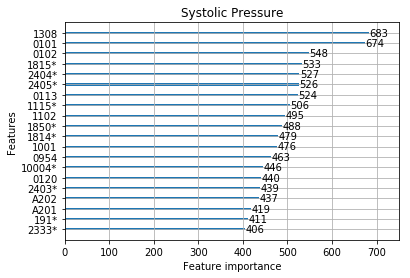

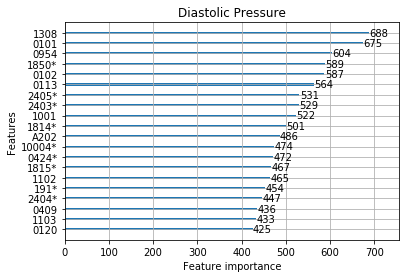

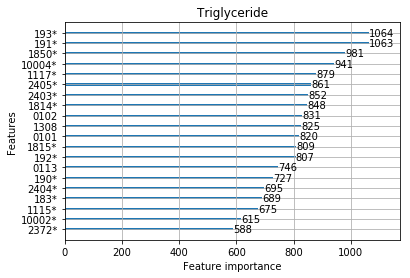

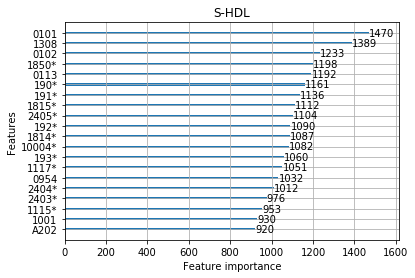

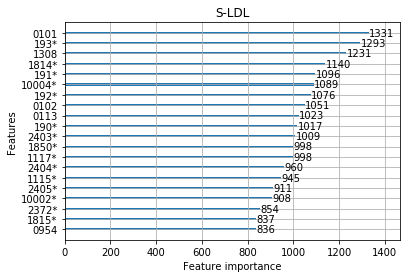

In [56]:
for i in range(y_train.shape[1]):
    lgb.plot_importance(model_list[i],max_num_features=20)
    plt.title(name_list[i])

In [2]:
import pandas as pd
d = pd.read_csv('E:\\Data Science Laboratory\\kaggle\\train_cleaned_v1.csv')

In [3]:
d.shape

(49998, 28)